# KSI monitoring: úlohy

V tomto souboru se nachází hlavní tabulka statistik týkajících se úloh.

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from sqlalchemy import func, distinct, text, and_
import pandas as pd
from IPython.display import display, HTML, Markdown
import seaborn as sns
import numpy as np

import util
from util.year import year as current_year
from db import session
import model
from datetime import datetime

pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = [8, 6]
print(datetime.now())

2019-05-15 19:09:12.334454


In [7]:
evaluations = session.query(
    model.Task,
    func.count(distinct(model.User.id)).label('evals_count'),
).\
    join(model.Task.r_wave).filter(model.Wave.year == current_year.id).\
    join(model.Task.modules).\
    join(model.Module.evaluations).\
    join(model.Evaluation.r_user).\
    filter(model.User.role == 'participant')

evaluations_per_task = evaluations.\
    group_by(model.Task).order_by(model.Wave.id, model.Task.id)

evaluations_per_task_d = {
    task: evals_count
    for (task, evals_count) in evaluations_per_task.all()
}

In [8]:
successful_evaluations = evaluations_per_task.\
    filter(model.Evaluation.ok == True)

successful_evaluations_d = {
    task: evals_count
    for (task, evals_count) in successful_evaluations.all()
}

In [9]:
per_module = session.query(
    model.Evaluation.user.label('user_id'),
    func.count(model.Evaluation.id).label('eval_count'),
).\
    join(model.Evaluation.r_module).join(model.Module.r_task).\
    join(model.Task.r_wave).\
    filter(model.Wave.year == current_year.id).\
    group_by(model.Evaluation.user,
             model.Evaluation.module).subquery()

EVAL_LIMITS = [10, 30, 50]
problematic_tasks = {
    limit: {
        task: evals_count
        for (task, evals_count) in (
            evaluations.
            filter(model.Evaluation.ok == False).
            join(per_module, per_module.c.user_id == model.User.id).\
            group_by(model.Task).\
            filter(per_module.c.eval_count > limit).all()
        )
    }
    for limit in EVAL_LIMITS
}

In [10]:
posts_count = session.query(
    model.Task,
    func.count(model.Post.id)
).\
    join(model.Task.r_wave).\
    filter(model.Wave.year == current_year.id).\
    join(model.Task.discussion_posts).\
    group_by(model.Task).\
    all()

posts_count_dict = {
    task: count
    for (task, count) in posts_count
}

In [11]:
all_waves = session.query(model.Wave).\
    filter(model.Wave.year == current_year.id).\
    order_by(model.Wave.index).all()

large_tasks = util.task.large_tasks().all()

In [24]:
no_evaluations_per_task_and_user = session.query(
    model.Task,
    model.User,
    func.count(model.Evaluation.id),
).\
    join(model.Task.r_wave).filter(model.Wave.year == current_year.id).\
    join(model.Task.modules).\
    join(model.Module.evaluations).\
    join(model.Evaluation.r_user).\
    filter(model.User.role == 'participant').\
    group_by(model.Task, model.User).\
    all()

In [33]:
no_evaluations_dict = {}
for task, user, count in no_evaluations_per_task_and_user:
    if task in no_evaluations_dict:
        no_evaluations_dict[task].append(count)
    else:    
        no_evaluations_dict[task] = [count]
        
no_evaluations_avg = {
    task: np.average(counts)
    for task, counts in no_evaluations_dict.items()
}

no_evaluations_median = {
    task: np.median(counts)
    for task, counts in no_evaluations_dict.items()
}

In [46]:
def show_wave_stats(wave, max_evals_count):
    tasks = [
        (
            task,
            evaluations_per_task_d[task],
            successful_evaluations_d[task],
            successful_evaluations_d[task] / evaluations_per_task_d[task],
            evaluations_per_task_d[task]-successful_evaluations_d[task],
            problematic_tasks[10][task] if task in problematic_tasks[10] else 0,
            problematic_tasks[30][task] if task in problematic_tasks[30] else 0,
            problematic_tasks[50][task] if task in problematic_tasks[50] else 0,
            posts_count_dict[task] if task in posts_count_dict else 0,
            no_evaluations_avg[task] if task in no_evaluations_avg else '-',
            no_evaluations_median[task] if task in no_evaluations_median else '-',
            sorted(no_evaluations_dict[task])[-5:] if task in no_evaluations_dict else '-',
        )
        for task in evaluations_per_task_d
        if task.wave == wave.id
    ]
    tasks.sort(key=lambda x: (x[0] in large_tasks, x[0].id))

    df = pd.DataFrame(tasks, columns=[
        'Task',
        'All Evaluations',
        'Successful Evaluations',
        'Successful/All ratio',
        'N.O. Users failing on task now',
        'N.O. Users with more than 10 unsucc. evaluations',
        'N.O. Users with more than 30 unsucc. evaluations',
        'N.O. Users with more than 50 unsucc. evaluations',
        'Discussion Posts Count',
        'Average N.O. Evaluations Per User',
        'Median N.O. Evaluations Per User',
        'Some Maximum Evaluations Counts',
    ]).set_index('Task')
    
    s = df.style
    
    s.background_gradient(subset=[
        'N.O. Users failing on task now',
        'N.O. Users with more than 10 unsucc. evaluations',
        'N.O. Users with more than 30 unsucc. evaluations',
        'N.O. Users with more than 50 unsucc. evaluations',
        'Average N.O. Evaluations Per User',
        'Median N.O. Evaluations Per User',        
    ], cmap=sns.light_palette("red", as_cmap=True))
    
    s.background_gradient(
        subset=['Successful/All ratio'],
        cmap=sns.light_palette("green", as_cmap=True)
    )
    
    s.background_gradient(
        subset=['Discussion Posts Count'],
        cmap=sns.light_palette("orange", as_cmap=True)
    )
    
    s.bar(subset=['All Evaluations'], color='#5fd65f', vmin=0, vmax=max_evals_count)
    
    s.format({
        'Successful/All ratio': '{:,.1%}'.format,
        'Average N.O. Evaluations Per User': '{:.2f}'.format,
    })
    
    display(Markdown('## {name}'.format(name=wave.caption)))
    display(s)

max_evals_count = max(evaluations_per_task_d.values())
    
for wave in all_waves:
    show_wave_stats(wave, max_evals_count)

## Nultá vlna

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations,Discussion Posts Count,Average N.O. Evaluations Per User,Median N.O. Evaluations Per User,Some Maximum Evaluations Counts
Task,,,,,,,,,,,
Vítej v KSI,680,680,100.0%,0,99,17,3,0,1.49,1,"[4, 5, 5, 5, 6]"
Vaření proměnných,508,497,97.8%,11,189,29,7,0,4.36,3,"[21, 21, 21, 25, 37]"
Seznámení s pythonem,438,413,94.3%,25,132,24,6,7,2.64,2,"[17, 18, 20, 21, 29]"
Složitost,420,411,97.9%,9,120,20,5,0,4.25,2,"[26, 26, 27, 28, 30]"
Korektnost,397,369,92.9%,28,134,25,5,0,3.96,1,"[31, 36, 38, 39, 50]"
Úvod do seznamů,350,340,97.1%,10,199,41,14,16,8.46,7,"[31, 31, 31, 32, 33]"
Funkce,285,267,93.7%,18,89,19,5,13,2.63,1,"[14, 16, 22, 23, 26]"
Start pro zkušené,428,427,99.8%,1,11,0,0,1,1.05,1,"[2, 2, 2, 2, 2]"
Asymptotická složitost,288,224,77.8%,64,170,39,13,0,6.01,3,"[26, 27, 29, 35, 58]"


## Hrubá síla

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations,Discussion Posts Count,Average N.O. Evaluations Per User,Median N.O. Evaluations Per User,Some Maximum Evaluations Counts
Task,,,,,,,,,,,
Rekurze,240,240,100.0%,0,82,26,9,8,2.27,1,"[11, 11, 12, 15, 19]"
Brute-force,240,239,99.6%,1,38,6,1,8,1.60,1,"[7, 8, 10, 12, 26]"
Permutace,214,208,97.2%,6,78,20,7,18,2.69,1,"[11, 14, 16, 19, 39]"
Variace s opakováním,230,229,99.6%,1,137,38,11,6,4.70,3,"[19, 20, 20, 21, 23]"
Variace bez opakování,196,193,98.5%,3,53,12,5,15,1.78,1,"[7, 7, 8, 9, 14]"
Generování podmnožin,179,174,97.2%,5,103,28,10,34,4.32,2,"[17, 17, 21, 21, 23]"
Backtracking,145,142,97.9%,3,30,10,3,10,1.50,1,"[4, 5, 5, 7, 9]"
Problém osmi dam,100,96,96.0%,4,26,11,2,2,1.67,1,"[4, 5, 5, 5, 6]"
Sebe-referenční test,167,156,93.4%,11,91,25,8,25,4.20,2,"[18, 19, 20, 22, 27]"


## Rozděl a panuj

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations,Discussion Posts Count,Average N.O. Evaluations Per User,Median N.O. Evaluations Per User,Some Maximum Evaluations Counts
Task,,,,,,,,,,,
Zmenši a panuj,151,150,99.3%,1,3,2,0,0,1.15,1,"[2, 3, 3, 3, 5]"
Transformuj a panuj,115,106,92.2%,9,54,18,6,11,2.73,2,"[12, 13, 13, 15, 22]"
Rozděl a panuj,122,121,99.2%,1,93,35,12,2,10.35,8,"[28, 31, 32, 37, 64]"
Binární vyhledávání,109,108,99.1%,1,62,23,9,18,3.69,2,"[13, 15, 15, 16, 26]"
QuickSort,107,107,100.0%,0,62,26,9,11,4.22,3,"[13, 13, 13, 17, 18]"
Rekurzivní volání,103,101,98.1%,2,90,37,12,9,9.28,7,"[21, 22, 26, 32, 42]"
Rozděluj a slučuj,60,60,100.0%,0,0,0,0,24,1.00,1,"[1, 1, 1, 1, 1]"
Binárne vyhľadávanie 2.0,76,76,100.0%,0,0,0,0,19,1.00,1,"[1, 1, 1, 1, 1]"
Karlík jede na soustředění,72,72,100.0%,0,0,0,0,15,1.00,1,"[1, 1, 1, 1, 1]"


## Dynamické programování

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations,Discussion Posts Count,Average N.O. Evaluations Per User,Median N.O. Evaluations Per User,Some Maximum Evaluations Counts
Task,,,,,,,,,,,
Úvod do dynamického programování,101,97,96.0%,4,43,19,6,2,2.15,1,"[6, 6, 7, 7, 10]"
Překrývající se problémy,86,66,76.7%,20,77,37,12,12,21.40,14.5,"[62, 83, 103, 113, 168]"
Bottom-up,68,68,100.0%,0,21,13,5,15,1.59,1,"[3, 3, 5, 5, 6]"
Rekurentné vzťahy,66,66,100.0%,0,35,18,6,0,6.61,3,"[24, 25, 28, 36, 47]"
Rekonstrukce řešení,56,53,94.6%,3,27,15,6,10,2.66,1.5,"[7, 8, 10, 11, 11]"
Nejdelší rostoucí podposloupnost,52,51,98.1%,1,49,29,9,5,12.67,9,"[29, 33, 38, 43, 58]"
Batoh,52,52,100.0%,0,42,23,7,3,7.52,6,"[15, 19, 22, 27, 31]"
Mince,49,46,93.9%,3,26,15,5,12,4.43,2,"[13, 15, 19, 20, 23]"
LosKarlosovské součty,38,36,94.7%,2,17,9,3,0,5.79,4,"[13, 14, 16, 16, 20]"


## NP-těžká vlna

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations,Discussion Posts Count,Average N.O. Evaluations Per User,Median N.O. Evaluations Per User,Some Maximum Evaluations Counts
Task,,,,,,,,,,,
Opakování složitosti,73,73,100.0%,0,54,29,11,2,4.62,4,"[7, 7, 7, 7, 12]"
Složitostní třídy,60,60,100.0%,0,45,24,10,0,5.12,4,"[12, 12, 14, 15, 22]"
NP aneb ověřování řešení,52,50,96.2%,2,35,21,7,0,4.79,4,"[9, 9, 10, 13, 13]"
Redukce,68,48,70.6%,20,64,32,9,11,22.10,15,"[56, 65, 80, 81, 176]"
Trénink redukcí,45,45,100.0%,0,7,4,2,0,2.38,2,"[3, 3, 4, 7, 7]"
O NP-úplných problémoch,40,37,92.5%,3,28,19,5,4,6.20,4,"[13, 14, 16, 16, 40]"
NP hra a řešení složitých problémů,36,36,100.0%,0,19,13,4,0,3.33,2,"[8, 8, 10, 10, 15]"
Strategie pro NP hru,23,19,82.6%,4,19,11,3,24,8.00,5,"[12, 13, 15, 25, 28]"
Tvorba karty,29,29,100.0%,0,0,0,0,14,1.00,1,"[1, 1, 1, 1, 1]"


## Statistika velkých úloh

In [16]:
per_module = session.query(
    model.Wave,
    model.Task,
    model.Evaluation.user.label('user_id'),
    model.Evaluation.module.label('module_id'),
    func.max(model.Evaluation.points).label('points'),
    model.Module.max_points.label('max_points'),
).\
    join(model.Evaluation.r_module).\
    filter(model.Module.type == model.ModuleType.GENERAL).\
    join(model.Module.r_task).join(model.Task.r_wave).\
    filter(model.Wave.year == current_year.id).\
    group_by(model.Task, model.Evaluation.user, model.Evaluation.id).\
    order_by(model.Wave.id)

norm_points = [
    pm.points / pm.max_points
    for pm in per_module
]

df = pd.DataFrame(per_module.all())
df['norm_points'] = norm_points
grouped = df.groupby('Task')

per_task = pd.DataFrame(OrderedDict((
    ('Wave', grouped.Wave.first()),
    ('Solved count', grouped.user_id.count()),
    ('Max Points', grouped.max_points.first()),
    ('Points Average', grouped.points.mean()),
    ('Points Median', grouped.points.median()),    
    ('Points Average Normalized', grouped.norm_points.mean()),
    ('Points Median Normalized', grouped.norm_points.median()),
)))
s = per_task.style
s.format({
    'Points Average': '{:.2f}'.format,
    'Points Average Normalized': '{:,.1%}'.format,
    'Points Median Normalized': '{:,.1%}'.format,
})

s.background_gradient(subset=[
    'Solved count',
    'Points Average Normalized',
    'Points Median Normalized',
], cmap=sns.light_palette("green", as_cmap=True))

s.background_gradient(subset=[
    'Points Median',
    'Points Average',
], cmap=sns.light_palette("blue", as_cmap=True))

display(s)

,Wave,Solved count,Max Points,Points Average,Points Median,Points Average Normalized,Points Median Normalized
Task,,,,,,,
Jigsaw Sudoku,Hrubá síla,54,10,7.76,8,77.6%,80.0%
Einsteinova hádanka,Hrubá síla,42,10,6.04,5,60.4%,50.0%
Tučňáčí párty,Hrubá síla,85,10,7.56,8,75.6%,80.0%
Rozděluj a slučuj,Rozděl a panuj,60,10,4.88,5,48.8%,50.0%
Binárne vyhľadávanie 2.0,Rozděl a panuj,76,10,8.44,9.25,84.4%,92.5%
Karlík jede na soustředění,Rozděl a panuj,72,10,7.46,7.75,74.6%,77.5%
Karlík v Karlově,Rozděl a panuj,19,5,4.16,3,83.2%,60.0%
LosKarlosovské součty,Dynamické programování,33,7,4.47,6.5,63.8%,92.9%
Trpasličí důl,Dynamické programování,32,10,8.97,10,89.7%,100.0%


## Kolik řešitelů získalo kolik bodů za velké úlohy

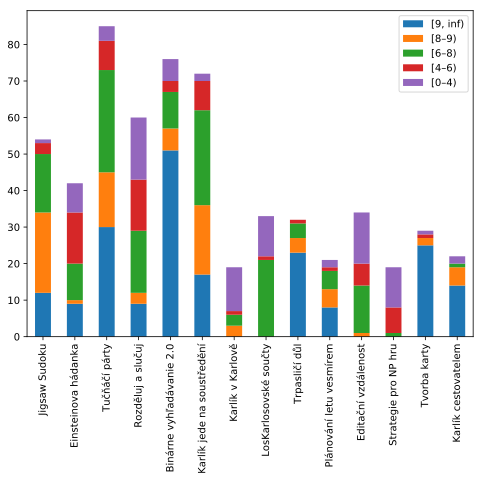

In [18]:
gained_points = pd.DataFrame(OrderedDict((
    ('[9, inf)', df[df['points'] >= 9].groupby('Task').points.count()),    
    ('[8–9)', df[(df['points'] >= 8) & (df['points'] < 9)].groupby('Task').points.count()),    
    ('[6–8)', df[(df['points'] >= 6) & (df['points'] < 8)].groupby('Task').points.count()),
    ('[4–6)', df[(df['points'] >= 4) & (df['points'] < 6)].groupby('Task').points.count()),
    
    ('[0–4)', df[(df['points'] >= 0) & (df['points'] < 4)].groupby('Task').points.count()),
)))
gained_points.plot.bar(stacked=True);

## Předchozí tabulka normalizovaná maximálním počtem bodů za úlohu

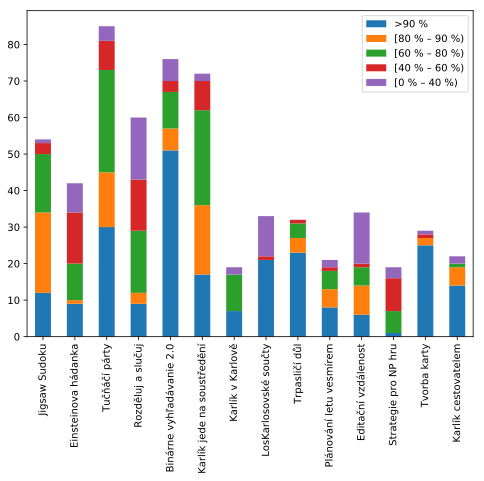

In [19]:
gained_points_norm = pd.DataFrame(OrderedDict((
    ('>90 %', df[df['norm_points'] >= .9].groupby('Task').norm_points.count()),    
    ('[80 % – 90 %)', df[(df['norm_points'] >= .8) & (df['norm_points'] < .9)].groupby('Task').norm_points.count()),
    ('[60 % – 80 %)', df[(df['norm_points'] >= .6) & (df['norm_points'] < .8)].groupby('Task').norm_points.count()),
    ('[40 % – 60 %)', df[(df['norm_points'] >= .4) & (df['norm_points'] < .6)].groupby('Task').norm_points.count()),
    ('[0 % – 40 %)', df[(df['norm_points'] >= 0) & (df['norm_points'] < .4)].groupby('Task').norm_points.count()),
)))
gained_points_norm.plot.bar(stacked=True);